# Multi-layer FNN on MNIST

This is MLP (784-X^W-10) on MNIST. SGD algorithm (lr=0.1) with 100 epoches.

 

In [1]:
import os, sys
import numpy as np
from matplotlib.pyplot import *
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import itertools

%matplotlib inline

In [2]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0, is_reg=False):

    if is_reg:
        valid_loss_str     = lines0[-5]
        valid_accuracy_str = lines0[-6]
        train_loss_str     = lines0[-8]
        train_accuracy_str = lines0[-9]
        average_time_str   = lines0[-10]        
        run_time_str       = lines0[-11]   
        
    else: 
        valid_loss_str     = lines0[-6]
        valid_accuracy_str = lines0[-7]
        train_loss_str     = lines0[-10]
        train_accuracy_str = lines0[-11]
        average_time_str   = lines0[-12]        
        run_time_str       = lines0[-13]


    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(lines0):
    line_str = ''.join(lines0)
    idx = line_str.find("Total params")
    param_str = line_str[idx+14:idx+14+20] # 14 is the length of string "Total params: "
    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

#### Extract results from diary file

    1. Number of params
    2. Loss/Accuarcy for training/testing
    3. Runing time

In [74]:
results_dir = '../results/fnn_mnist_permuted_label_t500_all_high'
       
depth = [2]# [1,2,3,4,5]
width = [400]# [50,100,200,400]
dim   = [0,1000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000,170000,180000,190000,200000,210000,220000,230000,240000,250000,260000,270000,280000,290000,300000]
# dim =[0]

########## 1. filename list of diary ########################
diary_names = []
for subdir, dirs, files in os.walk(results_dir):
    for file in files:
        
        if file == 'diary':
            fname = os.path.join(subdir, file)
            diary_names.append(fname)
            

########## 2. Construct stats (width, depth, dim) ##########
# acc_test_all : Tensor (width, depth, dim)
# num_param_all: Tensor (width, depth)
# acc_solved_all:  Tensor (width, depth)
# dim_solved_all:  Tensor (width, depth)
############################################################
nw, nd, nn= len(width), len(depth), len(dim)

acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
num_param_all = np.zeros((len(width), len(depth)))
acc_solved_all = np.zeros((len(width), len(depth)))
dim_solved_all = np.zeros((len(width), len(depth)))

mode = 3         # {0: test loss, 1: test acc}
error_files = [] #  record the error file

# 2.1 construct acc_test_all and num_param_all
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            # 2.1.1 Read the results, 
            for f in diary_names:
                if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                    # print "%d is in" % d + f
                    
                    with open(f,'r') as ff:
                        lines0 = ff.readlines()
                        try:
                            R = extract_num(lines0)
                            R = np.array(R)

                        except ValueError:
                            error_files.append((w,ll,d))
                            R = np.zeros(len(R))
                            print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                            # break
                            
                            
            # 2.1.2 Assign the results
            r = R[mode]  
            acc_test_all[id_w,id_ll,id_d]=r
            if d==0:
                num_param_all[id_w,id_ll]=parse_num_params(lines0) 
                
# 2.2 construct acc_solved_all and dim_solved_all           
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            r = acc_test_all[id_w,id_ll,id_d]
            if d==0:
                test_acc_bl = r # 1.0 # r        
                # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
            else:
                test_acc = r
                if test_acc>test_acc_bl*0.9:
                    acc_solved_all[id_w,id_ll]=test_acc
                    dim_solved_all[id_w,id_ll]=d
                    # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
                    # print "\n"
                    break
                    

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[:,:,0]
acc_solve = acc_base*0.9


In [84]:
print "Baseline results"
print acc_test_all[:,:,:]

print "# Parmas"
print num_param_all

print "Cross-line results"
print acc_solved_all

print "Cross-line Dim"
print dim_solved_all

print dim[15]
print acc_test_all[:,:,-1]  

Baseline results
[[[ 0.6174   0.11322  0.17218  0.24892  0.32556  0.39744  0.46654  0.53872
    0.60514  0.66908  0.72652  0.78054  0.81432  0.85036  0.87028  0.88712
    0.90152  0.91366  0.91762  0.92156  0.92516  0.93036  0.9297   0.93134
    0.93092  0.93148  0.9277   0.93102  0.93694  0.93462  0.9339   0.93198]]]
# Parmas
[[ 478410.]]
Cross-line results
[[ 0.60514]]
Cross-line Dim
[[ 70000.]]
140000
[[ 0.93198]]


#### List the config of depth and width, which yields errors in training

In [47]:
E_width, E_depth, E_dim = [],[],[]
for item in error_files:
    E_width.append(item[0]) 
    E_depth.append(item[1])
    E_dim.append(item[2])

str_E_width = "".join(str(E_width)).replace(',', '')
str_E_depth = "".join(str(E_depth)).replace(',', '')
str_E_dim   = "".join(str(E_dim)).replace(',', '')

print "Error in the following configs: width, depth and dim"
print str_E_width
print str_E_depth
print str_E_dim

print "Shape of accuracy tensor: " + str(acc_test_all.shape)

print str(acc_test_all[0,0,:])

Error in the following configs: width, depth and dim
[]
[]
[]
Shape of accuracy tensor: (1, 1, 32)
[ 0.11356  0.1169   0.22276  0.32912  0.42362  0.50796  0.59456  0.68228
  0.74778  0.7934   0.8173   0.84238  0.847    0.85462  0.8422   0.1092
  0.10796  0.10698  0.10658  0.10546  0.10534  0.1054   0.10634  0.10576
  0.10468  0.10436  0.10384  0.10286  0.10264  0.10276  0.1032   0.10328]


-------------------------

#### Check the accuracy of specific depth and width, along different dim

In [59]:
def check_cfg_results (depth, width, lines0): 
    for d in dim:
        # 1. read the results
        for f in diary_names:
            if '_'+str(d)+'_'+str(depth)+'_'+str(width)+'/' in f:
                # print "%d is in" % d + f
                diary_names_ordered.append(f)
                with open(f,'r') as ff:
                    lines0 = ff.readlines()
                    try:
                        # print lines0
                        param_num = parse_num_params(lines0)
                        R = extract_num(lines0)
                        print R[1]

                    except ValueError:
                        print "Error: Can not read"
                        break                                               

Reshape the tensor to 1D for plots

In [76]:


fig_width = width*len(depth)
fig_depth = list(itertools.chain.from_iterable(itertools.repeat(x, len(width)) for x in depth))

print fig_width
print fig_depth
print num_param_all
print dim_solved_all
fig_params_1d = num_param_all.reshape(len(depth)*len(width),order='F')
dim_solved_all_1d = dim_solved_all.reshape(len(depth)*len(width),order='F')
acc_solved_all_1d = acc_solved_all.reshape(len(depth)*len(width),order='F')
print fig_params_1d
print dim_solved_all_1d

[400]
[2]
[[ 478410.]]
[[ 70000.]]
[ 478410.]
[ 70000.]


### Testing Accuracy wrt. Width, Depth and Dim

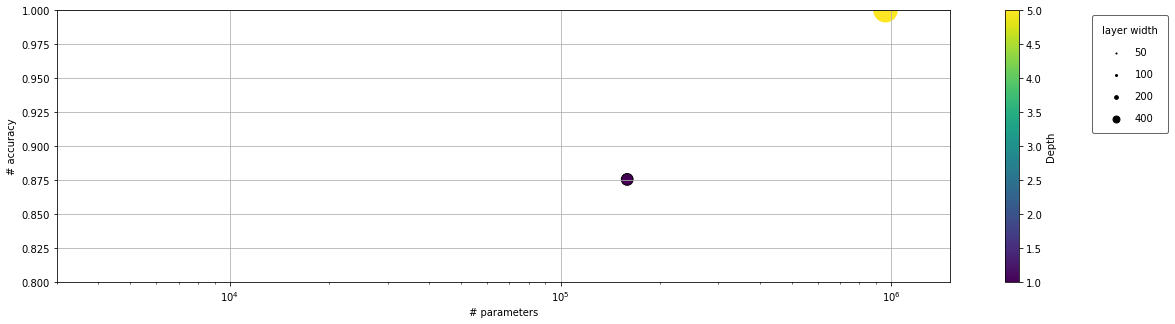

In [9]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(acc_test_all.shape[2]):
    acc = acc_test_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        plt.scatter(fig_params_1d, 0.9*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.8, 1.0)
ax.set_xlim(0.3E4, 1.5E6)

plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

 
    

#### Testing Accuracy of Intrinsic dim for #parameters

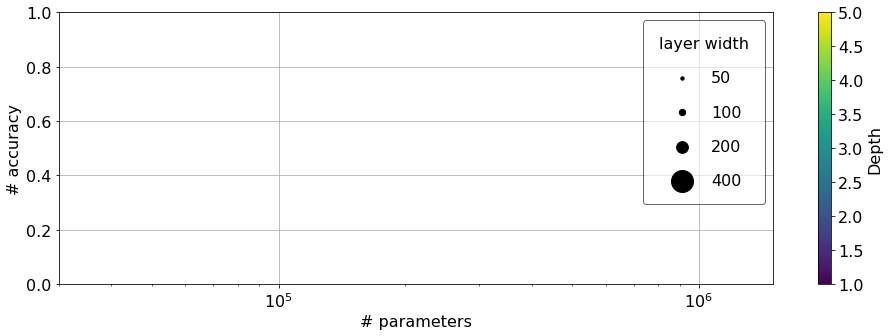

In [19]:
fig = plt.figure(figsize=(16,5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, acc_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.3E5, 1.5E6)


plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#### Intrinsic dim for #parameters

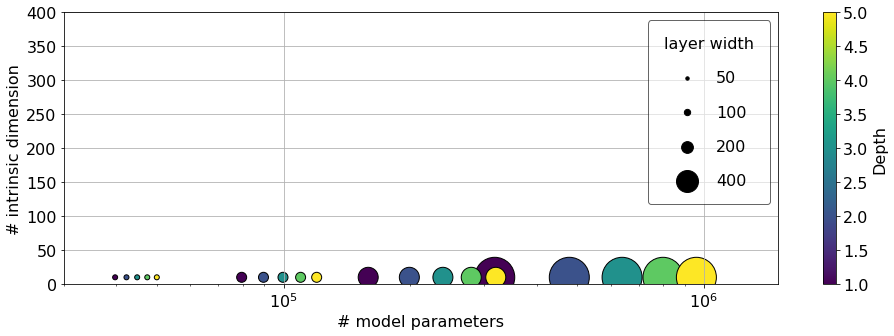

In [23]:
fig = plt.figure(figsize=(16,5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, dim_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')

ax.grid(True)
ax.set_ylim(0, 400)

plt.xlabel('# model parameters')
plt.ylabel('# intrinsic dimension')
ax.set_xlim(0.3E5, 1.5E6)

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w",loc='best')

fig.savefig("fnn_dim_global_nl.pdf", bbox_inches='tight')

## Performance comparison with Baseline

In [9]:
fig = plt.figure(figsize=(35,25))
fig.subplots_adjust(hspace=0.3)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

for i in range(nw):
    for j in range(nd):
        if j>0:
            id = i*nd+j+1
            ax = plt.subplot(nw, nd, id)

            plt.scatter(dim, acc_test_all[i,j,:], edgecolor="k", facecolor="w", s=60 )
            ax.plot(dim, acc_test_all[i,j,0]*np.ones(nn)*0.9,'r-.', label="Testing: baseline")
            ax.set_xlabel('Intrinsic Dim')
            ax.set_ylabel('Accuracy')
            ax.set_title('width %d, depth %d' %(width[i], depth[j]))
            plt.grid()
            ax.set_ylim([-0.1,1.1])

fig.savefig("fnn_all_configs_nl.pdf", bbox_inches='tight')

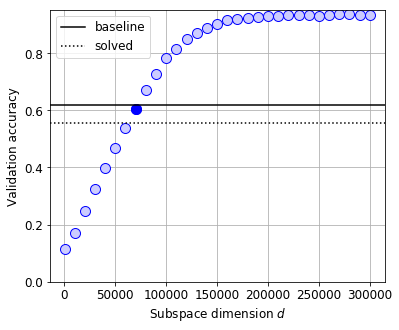

In [81]:
i,j=0,0

fig, ax = subplots(figsize=(6,5) )
  
font = {'size'   : 12}
matplotlib.rc('font', **font)


plot(dim[1:], acc_test_all[0,0,1:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
plot(dim_solved_all[i,j], acc_solved_all[i,j], 'o', mec='b', mfc='b', ms=10)
axhline(acc_test_all[0,0,0], ls='-', color='k',label='baseline')
axhline(acc_test_all[0,0,0] * .9, ls=':', color='k',label='solved')
plt.legend()
ax.set_xlabel('Subspace dimension $d$')
ax.set_ylabel('Validation accuracy')

# ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
ax.set_ylim([0.0,0.95])
        
fig.savefig("figs/fnn_mnistPL_W"+str(width[i])+"_L"+str(depth[j])+".pdf", bbox_inches='tight')


In [34]:
acc_test_all

array([[[ 0.61876,  0.11224,  0.16344,  0.21748,  0.26432,  0.3095 ,
          0.35228,  0.39068,  0.42614,  0.45558,  0.48398,  0.5137 ,
          0.53654,  0.55952,  0.57662,  0.59224,  0.60614,  0.61776,
          0.62912,  0.63658,  0.64432,  0.64564,  0.64928,  0.65652,
          0.6527 ,  0.65   ,  0.62032,  0.10548,  0.10428,  0.1036 ,
          0.10502,  0.10298]]])

In [16]:
results_dir = '/home/users/chunyuan.li/public_results/chun'
       
depth = [1,2,3,4,5]
width = [50,100,200,400]
dim   = [0,1000,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000,170000,180000,190000,200000,210000,220000,230000,240000,250000,260000,270000,280000,290000,300000]
# dim =[0]

########## 1. filename list of diary ########################
diary_names = []
for subdir, dirs, files in os.walk(results_dir):
    if '5393fd2_lrb_fnn_mnist_t500_pl' in subdir:
        for subdir, dirs, files in os.walk(subdir):
            for file in files:
                if file == 'diary':
                    fname = os.path.join(subdir, file)
                    diary_names.append(fname)
            
print diary_names
########## 2. Construct stats (width, depth, dim) ##########
# acc_test_all : Tensor (width, depth, dim)
# num_param_all: Tensor (width, depth)
# acc_solved_all:  Tensor (width, depth)
# dim_solved_all:  Tensor (width, depth)
############################################################
nw, nd, nn= len(width), len(depth), len(dim)

acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
num_param_all = np.zeros((len(width), len(depth)))
acc_solved_all = np.zeros((len(width), len(depth)))
dim_solved_all = np.zeros((len(width), len(depth)))

mode = 3         # {0: test loss, 1: test acc}
error_files = [] #  record the error file

# 2.1 construct acc_test_all and num_param_all
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            # 2.1.1 Read the results, 
            for f in diary_names:
                if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                    # print "%d is in" % d + f
                    
                    with open(f,'r') as ff:
                        lines0 = ff.readlines()
                        try:
                            R = extract_num(lines0)
                            R = np.array(R)

                        except ValueError:
                            error_files.append((w,ll,d))
                            R = np.zeros(len(R))
                            print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                            # break
                            
                            
            # 2.1.2 Assign the results
            r = R[mode]  
            acc_test_all[id_w,id_ll,id_d]=r
            if d==0:
                num_param_all[id_w,id_ll]=parse_num_params(lines0) 
                
# 2.2 construct acc_solved_all and dim_solved_all           
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            r = acc_test_all[id_w,id_ll,id_d]
            if d==0:
                test_acc_bl = r # 1.0 # r        
                # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
            else:
                test_acc = r
                if test_acc>test_acc_bl*0.9:
                    acc_solved_all[id_w,id_ll]=test_acc
                    dim_solved_all[id_w,id_ll]=d
                    # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
                    # print "\n"
                    break
                    

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[:,:,0]
acc_solve = acc_base*0.9




['/home/users/chunyuan.li/public_results/chun/171019_004350_5393fd2_lrb_fnn_mnist_t500_pl_10000_2_50/diary', '/home/users/chunyuan.li/public_results/chun/171019_044334_5393fd2_lrb_fnn_mnist_t500_pl_160000_4_400/diary', '/home/users/chunyuan.li/public_results/chun/171019_055040_5393fd2_lrb_fnn_mnist_t500_pl_210000_5_200/diary', '/home/users/chunyuan.li/public_results/chun/171019_044401_5393fd2_lrb_fnn_mnist_t500_pl_180000_4_400/diary', '/home/users/chunyuan.li/public_results/chun/171019_013656_5393fd2_lrb_fnn_mnist_t500_pl_150000_2_200/diary', '/home/users/chunyuan.li/public_results/chun/171019_020157_5393fd2_lrb_fnn_mnist_t500_pl_150000_3_50/diary', '/home/users/chunyuan.li/public_results/chun/171018_234551_5393fd2_lrb_fnn_mnist_t500_pl_290000_1_200/diary', '/home/users/chunyuan.li/public_results/chun/171018_234410_5393fd2_lrb_fnn_mnist_t500_pl_150000_1_50/diary', '/home/users/chunyuan.li/public_results/chun/171019_034518_5393fd2_lrb_fnn_mnist_t500_pl_60000_4_100/diary', '/home/users/c

Error. Can not read config: depth 1, width 50 and dim 240000.
Error. Can not read config: depth 1, width 50 and dim 250000.
Error. Can not read config: depth 1, width 50 and dim 260000.
Error. Can not read config: depth 1, width 50 and dim 270000.
Error. Can not read config: depth 1, width 50 and dim 280000.
Error. Can not read config: depth 1, width 50 and dim 290000.
Error. Can not read config: depth 1, width 50 and dim 300000.
Error. Can not read config: depth 2, width 50 and dim 50000.
Error. Can not read config: depth 2, width 50 and dim 60000.
Error. Can not read config: depth 2, width 50 and dim 70000.
Error. Can not read config: depth 2, width 50 and dim 80000.
Error. Can not read config: depth 2, width 50 and dim 90000.
Error. Can not read config: depth 2, width 50 and dim 100000.
Error. Can not read config: depth 2, width 50 and dim 110000.
Error. Can not read config: depth 2, width 50 and dim 120000.
Error. Can not read config: depth 2, width 50 and dim 130000.
Error. Can no

Error. Can not read config: depth 2, width 100 and dim 250000.
Error. Can not read config: depth 2, width 100 and dim 260000.
Error. Can not read config: depth 2, width 100 and dim 270000.
Error. Can not read config: depth 2, width 100 and dim 280000.
Error. Can not read config: depth 2, width 100 and dim 290000.
Error. Can not read config: depth 2, width 100 and dim 300000.
Error. Can not read config: depth 3, width 100 and dim 100000.
Error. Can not read config: depth 3, width 100 and dim 110000.
Error. Can not read config: depth 3, width 100 and dim 120000.
Error. Can not read config: depth 3, width 100 and dim 130000.
Error. Can not read config: depth 3, width 100 and dim 140000.
Error. Can not read config: depth 3, width 100 and dim 150000.
Error. Can not read config: depth 3, width 100 and dim 160000.
Error. Can not read config: depth 3, width 100 and dim 170000.
Error. Can not read config: depth 3, width 100 and dim 180000.
Error. Can not read config: depth 3, width 100 and dim 

In [101]:
acc_test_all[:,:,0]

array([[ 0.27594,  0.31596,  0.3499 ,  0.36754,  0.38018],
       [ 0.3715 ,  0.47786,  0.57946,  0.67088,  0.74454],
       [ 0.53088,  0.80302,  0.96492,  0.9866 ,  0.98634],
       [ 0.75504,  0.98788,  0.99904,  0.99666,  0.99444]])

In [102]:
acc_test_all[:,:,-1]

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.94928],
       [ 0.64388,  0.85058,  0.95746,  0.98312,  0.99086]])

In [20]:
i,j=3,4
dim_, acc_train_ = dim, acc_test_all[i,j,:]
print ','.join(['[%i, %s]' % (dim_[n], acc_train_[n]) for n in xrange(len(dim_))])


[0, 0.99444],[1000, 0.11292],[10000, 0.15122],[20000, 0.19618],[30000, 0.24556],[40000, 0.29172],[50000, 0.3347],[60000, 0.3811],[70000, 0.42188],[80000, 0.46698],[90000, 0.50712],[100000, 0.54436],[110000, 0.5939],[120000, 0.63058],[130000, 0.67804],[140000, 0.71868],[150000, 0.7643],[160000, 0.80814],[170000, 0.84078],[180000, 0.87192],[190000, 0.90398],[200000, 0.92432],[210000, 0.94128],[220000, 0.95406],[230000, 0.96462],[240000, 0.97232],[250000, 0.97732],[260000, 0.9809],[270000, 0.98446],[280000, 0.98714],[290000, 0.98706],[300000, 0.99086]


In [108]:
num_param_all

array([[  39760.,   42310.,   44860.,   47410.,   49960.],
       [  79510.,   89610.,   99710.,  109810.,  119910.],
       [ 159010.,  199210.,  239410.,  279610.,  319810.],
       [ 318010.,  478410.,  638810.,  799210.,  959610.]])

(0.0, 1.0)

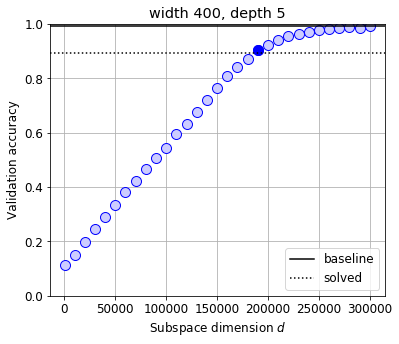

In [18]:
i,j=3,4

fig, ax = subplots(figsize=(6,5) )
  
font = {'size'   : 12}
matplotlib.rc('font', **font)

plot(dim[1:], acc_test_all[i,j,1:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
plot(dim_solved_all[i,j], acc_solved_all[i,j], 'o', mec='b', mfc='b', ms=10)
axhline(acc_test_all[i,j,0], ls='-', color='k',label='baseline')
axhline(acc_test_all[i,j,0] * .9, ls=':', color='k',label='solved')
plt.legend()
ax.set_xlabel('Subspace dimension $d$')
ax.set_ylabel('Validation accuracy')

ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
ax.set_ylim([0.0,1.00])
        
# fig.savefig("figs/fnn_mnistPL_W"+str(width[i])+"_L"+str(depth[j])+".pdf", bbox_inches='tight')


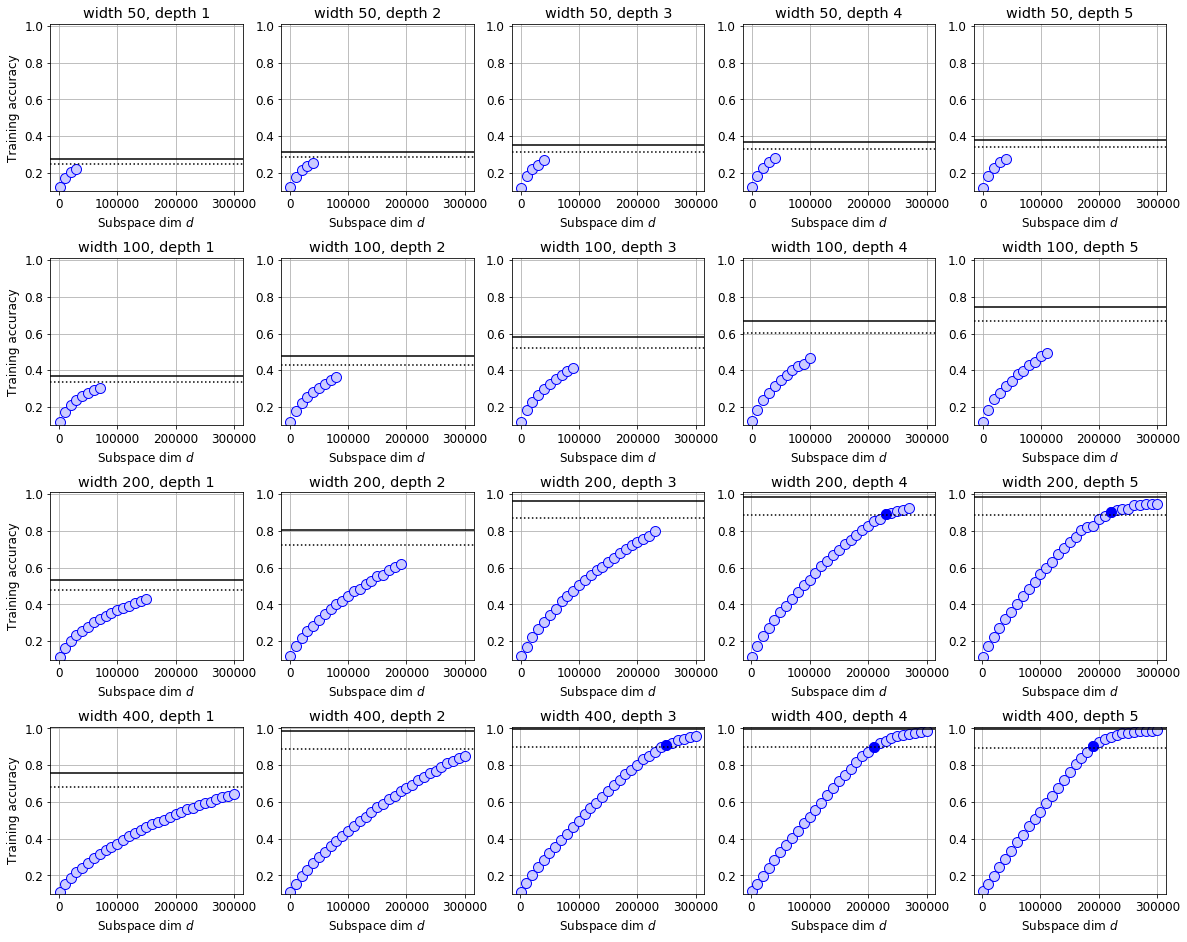

In [116]:
fig = plt.figure(figsize=(20,16))
fig.subplots_adjust(hspace=0.4)

acc_solved_all

for i in range(nw):
    for j in range(nd):
        id = i*nd+j+1
        ax = plt.subplot(nw, nd, id)

        plot(dim[1:], acc_test_all[i,j,1:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
        plot(dim_solved_all[i,j], acc_solved_all[i,j], 'o', mec='b', mfc='b', ms=10)
        axhline(acc_test_all[i,j,0], ls='-', color='k')
        axhline(acc_test_all[i,j,0] * .9, ls=':', color='k')
        ax.set_xlabel('Subspace dim $d$')
        if j==0:
            ax.set_ylabel('Training accuracy')
            
        ax.set_title('width %d, depth %d' %(width[i], depth[j]))
        plt.grid()
        ax.set_ylim([0.1,1.01])
        
fig.savefig("figs/fnn_mnist_pl_all_configs.pdf", bbox_inches='tight')

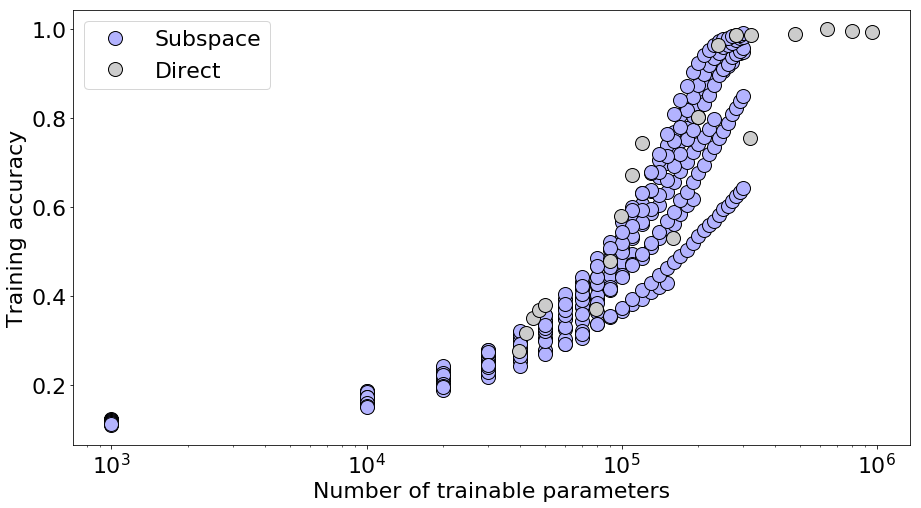

In [136]:
def figsize(width,height):
    rcParams['figure.figsize'] = (width,height)

font = {'size'   : 22}
matplotlib.rc('font', **font)



n_dim = len(dim) 
dim3 = np.repeat(dim, 4*5, axis=0).reshape([4, 5, n_dim],order='F')


param = num_param_all.reshape(20)
acc_direct = acc_test_all[:,:,0].reshape(20)

direct_md =  np.array([ (int(param[i]), acc_direct[i]) for i in range(20) ])

acc_test_md, num_trainable_md = acc_test_all.reshape(20*n_dim) , dim3.reshape(20*n_dim) 
subspace_md =  np.array([(int(num_trainable_md[i]), acc_test_md[i]) for i in range(20*n_dim) if (num_trainable_md[i]!=0 and acc_test_md[i]!=0.0)])

figsize(15, 8)
semilogx(subspace_md[:,0], subspace_md[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14, label='Subspace')
semilogx(direct_md[:,0], direct_md[:,1], 'o', mfc=(.8,.8,.8), mec='k', ms=14, label='Direct')

xlabel('Number of trainable parameters')
ylabel('Training accuracy')
plt.legend()
savefig('figs/mnist_pl_trainable_cmp_log.pdf', bbox_inches='tight')



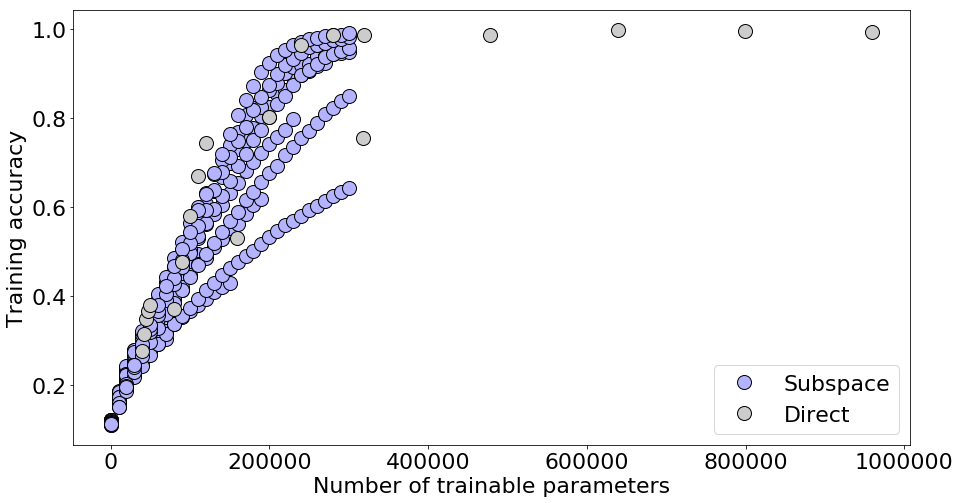

In [137]:
figsize(15, 8)
plot(subspace_md[:,0], subspace_md[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14, label='Subspace')
plot(direct_md[:,0], direct_md[:,1], 'o', mfc=(.8,.8,.8), mec='k', ms=14, label='Direct')
xlabel('Number of trainable parameters')
ylabel('Training accuracy')
plt.legend()
# savefig('mnist_small_direct.png')
savefig('figs/mnist_pl_trainable_cmp.pdf', bbox_inches='tight')

In [14]:
results_dir = '/home/users/chunyuan.li/public_results/chun/results_pl_pd2'
       
depth = [5]
width = [400]

########## 1. filename list of diary ########################
percentage_data = 0.5                    
# filename list of diary
diary_names = []
for subdir, dirs, files in os.walk(results_dir):
    if ("5_400_"+str(percentage_data) in subdir):
        # print subdir
        for file in files:
            if file == 'diary':
                fname = os.path.join(subdir, file)
                if int(fname.split('/')[-2].split('_')[-3]) == 5:
                    diary_names.append(fname)
                    

print "Number of diary files extracted: " + str(len(diary_names))
# print diary_names

dim =  []
for f in diary_names:
    d = int(f.split('/')[-2].split('_')[-4])
    dim.append(d)
dim = sorted(dim)
    
dim = sorted(list(set(dim)))


########## 2. Construct stats (width, depth, dim) ##########
# acc_test_all : Tensor (width, depth, dim)
# num_param_all: Tensor (width, depth)
# acc_solved_all:  Tensor (width, depth)
# dim_solved_all:  Tensor (width, depth)
############################################################
nn= len(dim)

acc_test_all  = np.zeros(len(dim))

mode = 3         # {0: test loss, 1: test acc}
error_files = [] #  record the error file

# 2.1 construct acc_test_all and num_param_all

for id_d in range(len(dim)):
    d, ll, w = dim[id_d],depth[0],width[0]

    # 2.1.1 Read the results, 
    for f in diary_names:
        if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'_'+str(percentage_data)+'/' in f:
            #print "%d is in" % d + f

            with open(f,'r') as ff:
                lines0 = ff.readlines()
                try:
                    R = extract_num(lines0)
                    R = np.array(R)
                    # print R

                except ValueError:
                    error_files.append((w,ll,d))
                    R = np.zeros(len(R))
                    print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                    # break


    # 2.1.2 Assign the results
    r = R[mode]  
    acc_test_all[id_d]=r
    if d==0:
        num_param_all=parse_num_params(lines0) 
                
# 2.2 construct acc_solved_all and dim_solved_all           

for id_d in range(len(dim)):
    d = dim[id_d]
    r = acc_test_all[id_d]
    if d==0:
        test_acc_bl = r # 1.0 # r        
        # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
    else:
        test_acc = r
        if test_acc>test_acc_bl*0.9:
            acc_solved_all=test_acc
            dim_solved_all=d
            # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
            # print "\n"
            break
                    

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[0]
acc_solve = acc_base*0.9




Number of diary files extracted: 33


In [15]:
print dim
print acc_test_all

print ','.join(['[%i, %s]' % (dim[n], acc_test_all[n]) for n in xrange(len(dim))])


[0, 1000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000]
[ 0.99156  0.11652  0.1764   0.23804  0.29904  0.3604   0.42488  0.48488
  0.54584  0.605    0.66688  0.73308  0.79204  0.84436  0.89172  0.92576
  0.95044  0.96692  0.97468  0.98328  0.98708  0.99308  0.9946   0.99728
  0.9982   0.99884  0.99884  0.99724  0.99804  0.9996   0.99988  0.99892]
[0, 0.99156],[1000, 0.11652],[10000, 0.1764],[20000, 0.23804],[30000, 0.29904],[40000, 0.3604],[50000, 0.42488],[60000, 0.48488],[70000, 0.54584],[80000, 0.605],[90000, 0.66688],[100000, 0.73308],[110000, 0.79204],[120000, 0.84436],[130000, 0.89172],[140000, 0.92576],[150000, 0.95044],[160000, 0.96692],[170000, 0.97468],[180000, 0.98328],[190000, 0.98708],[200000, 0.99308],[210000, 0.9946],[220000, 0.99728],[230000, 0.9982],[240000, 0.99884],[250000, 0.99884],[2

(0.0, 1.01)

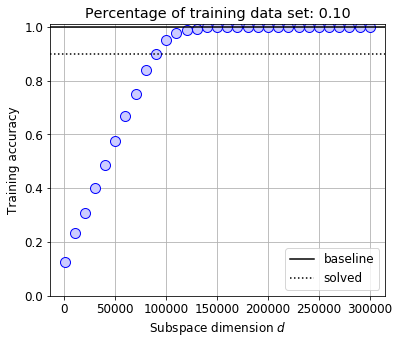

In [11]:
i,j=3,2

fig, ax = subplots(figsize=(6,5) )
  
font = {'size'   : 12}
matplotlib.rc('font', **font)

plot(dim[1:], acc_test_all[1:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
# plot(dim_solved_all, acc_solved_all, 'o', mec='b', mfc='b', ms=10)
axhline(acc_test_all[0], ls='-', color='k',label='baseline')
axhline(acc_test_all[0] * .9, ls=':', color='k',label='solved')
plt.legend()
ax.set_xlabel('Subspace dimension $d$')
ax.set_ylabel('Training accuracy')

ax.set_title('Percentage of training data set: %.2f' % percentage_data)
plt.grid()
ax.set_ylim([0.0,1.01])
        
# fig.savefig("figs/fnn_mnistPL_W"+str(width[i])+"_L"+str(depth[j])+".pdf", bbox_inches='tight')


In [221]:
prob5 = [0.09776, 0.11276, 0.09932, 0.1028, 0.097, 0.0922, 0.0958, 0.10408, 0.09876, 0.09952]
prob1 = [0.0974, 0.1128, 0.103, 0.1038, 0.0948, 0.094, 0.0912, 0.102, 0.098, 0.103]
prob0 = [0.1 for i in range(10)]
prob_ = [0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902, 0.1035, 0.09684, 0.09976]

import math
def entropy(prob):
    return sum([ -p* math.log(p) for p in prob])

print entropy(prob0)/math.log(50000)
print entropy(prob_)/math.log(50000)
print entropy(prob1)/math.log(5000)
print entropy(prob5)/math.log(25000)

print "Entrop of Y:"
print entropy(prob0)
print entropy(prob_)
print entropy(prob1)
print entropy(prob5)

0.212812594904
0.212667187512
0.270141089437
0.227242285477
Entrop of Y:
2.30258509299
2.30101181725
2.30084384767
2.30119879622
